# Metadata

```
Course:   DS 5001
Module:   10 Lab
Topic:    Sentiment Analysis of Novels 
Autho:    R.C. Alvarado

Purpose:  Use the NRC lexicon to explore sentiment in two novels.
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'novels'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [3]:
salex_csv = f'{data_home}/salex/salex_nrc.csv'

In [9]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from IPython.display import display, HTML

In [5]:
sns.set()

# Get Data

## Get Lexicon

In [6]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [8]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


## Get Novels

In [69]:
TOKENS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv').set_index(OHCO).sort_index()
LIB = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-LIB.csv").set_index('book_id').sort_index()
LIB['label'] = LIB.apply(lambda x: f"{x.author_id}: {x.name} ({x.genre_id})", 1)

In [70]:
TOKENS

pos term_str
book_id    chap_id para_num sent_num token_num              
adventures 1       0        1        0           DT        a
                                     1          NNP  scandal
                                     2          NNP       in
                                     3          NNP  bohemia
                   1        0        0           NN        i
...                                             ...      ...
usher      1       47       4        78          IN       of
                                     79          DT      the
                                     80          NN    house
                                     81          IN       of
                                     82         NNP    usher

[1500417 rows x 2 columns]

**Get `BOW` by chapter, `VOCAB`, `tfidf`, `dfidf`**

In [71]:
BOW = TOKENS.value_counts(OHCO[:2] + ['term_str']).to_frame('n').sort_index()
VOCAB = TOKENS.value_counts('term_str').to_frame('n').sort_index()
N = len(BOW.groupby(OHCO[:2]))
VOCAB['df'] = BOW.groupby('term_str').count()
VOCAB['dfidf'] = VOCAB.df * np.log2(N/VOCAB.df)
BOW['tf'] = (BOW.unstack().T / BOW.unstack().T.sum()).T.stack()
BOW['tfidf'] = BOW.tf * np.log2(N/VOCAB.df)

## Create `COMBO`

In [72]:
COMBO = TOKENS.join(LIB).join(SALEX, on='term_str').join(BOW, on=OHCO[:2] + ['term_str'])
COMBO = COMBO.drop(['n', 'tf'], axis=1)
COMBO = COMBO.sort_index()

In [75]:
COMBO

pos term_str genre_id  \
book_id    chap_id para_num sent_num token_num                          
adventures 1       0        1        0           DT        a        d   
                                     1          NNP  scandal        d   
                                     2          NNP       in        d   
                                     3          NNP  bohemia        d   
                   1        0        0           NN        i        d   
...                                             ...      ...      ...   
usher      1       47       4        78          IN       of        g   
                                     79          DT      the        g   
                                     80          NN    house        g   
                                     81          IN       of        g   
                                     82         NNP    usher        g   

                                               author_id  \
book_id    chap_id para_num sent_num token_num             
adventures 1       0        1        0             doyle   
                                     1             doyle   
                                     2             doyle   
                                     3             doyle   
                   1        0        0             doyle   
...                                                  ...   
usher      1       47       4        78              poe   
                                     79              poe   
                                     80              poe   
                                     81              poe   
                                     82              poe   

                                                                label  anger  \
book_id    chap_id para_num sent_num token_num                                 
adventures 1       0        1        0          doyle: adventures (d)    NaN   
                                     1          doyle: adventures (d)    0.0   
                                     2          doyle: adventures (d)    NaN   
                                     3          doyle: adventures (d)    NaN   
                   1        0        0          doyle: adventures (d)    NaN   
...                                                               ...    ...   
usher      1       47       4        78                poe: usher (g)    NaN   
                                     79                poe: usher (g)    NaN   
                                     80                poe: usher (g)    NaN   
                                     81                poe: usher (g)    NaN   
                                     82                poe: usher (g)    0.0   

                                                anticipation  disgust  fear  \
book_id    chap_id para_num sent_num token_num                                
adventures 1       0        1        0                   NaN      NaN   NaN   
                                     1                   0.0      0.0   1.0   
                                     2                   NaN      NaN   NaN   
                                     3                   NaN      NaN   NaN   
                   1        0        0                   NaN      NaN   NaN   
...                                                      ...      ...   ...   
usher      1       47       4        78                  NaN      NaN   NaN   
                                     79                  NaN      NaN   NaN   
                                     80                  NaN      NaN   NaN   
                                     81                  NaN      NaN   NaN   
                                     82                  0.0      0.0   0.0   

                                                joy  negative  positive  \
book_id    chap_id para_num sent_num token_num                            
adventures 1       0        1        0          NaN       NaN       NaN   
                       

In [76]:
COMBO.dropna()

pos    term_str genre_id  \
book_id    chap_id para_num sent_num token_num                             
adventures 1       0        1        1          NNP     scandal        d   
                   2        2        11          NN         sex        d   
                            3        10          VB        love        d   
                            4        7           JJ   abhorrent        d   
                            5        7           JJ     perfect        d   
...                                             ...         ...      ...   
usher      1       47       4        12          JJ      fierce        g   
                                     16          NN   whirlwind        g   
                                     40          NN      mighty        g   
                                     50          JJ  tumultuous        g   
                                     82         NNP       usher        g   

                                               author_id  \
book_id    chap_id para_num sent_num token_num             
adventures 1       0        1        1             doyle   
                   2        2        11            doyle   
                            3        10            doyle   
                            4        7             doyle   
                            5        7             doyle   
...                                                  ...   
usher      1       47       4        12              poe   
                                     16              poe   
                                     40              poe   
                                     50              poe   
                                     82              poe   

                                                                label  anger  \
book_id    chap_id para_num sent_num token_num                                 
adventures 1       0        1        1          doyle: adventures (d)    0.0   
                   2        2        11         doyle: adventures (d)    0.0   
                            3        10         doyle: adventures (d)    0.0   
                            4        7          doyle: adventures (d)    1.0   
                            5        7          doyle: adventures (d)    0.0   
...                                                               ...    ...   
usher      1       47       4        12                poe: usher (g)    1.0   
                                     16                poe: usher (g)    0.0   
                                     40                poe: usher (g)    1.0   
                                     50                poe: usher (g)    1.0   
                                     82                poe: usher (g)    0.0   

                                                anticipation  disgust  fear  \
book_id    chap_id para_num sent_num token_num                                
adventures 1       0        1        1                   0.0      0.0   1.0   
                   2        2        11                  1.0      0.0   0.0   
                            3        10                  0.0      0.0   0.0   
                            4        7                   0.0      1.0   1.0   
                            5        7                   1.0      0.0   0.0   
...                                                      ...      ...   ...   
usher      1       47       4        12                  0.0      1.0   1.0   
                                     16                  0.0      0.0   1.0   
                                     40                  0.0      0.0   1.0   
                                     50                  0.0      0.0   1.0   
                                     82                  0.0      0.0   0.0   

                                                joy  negative  positive  \
book_id    chap_id para_num sent_num token_num                            
adventures 1       0        1        1          0.0       1

# Sentiment by Book

In [108]:
BOOKS = COMBO.groupby(OHCO[:1])[emo_cols+['tfidf']].mean().join(LIB.label)

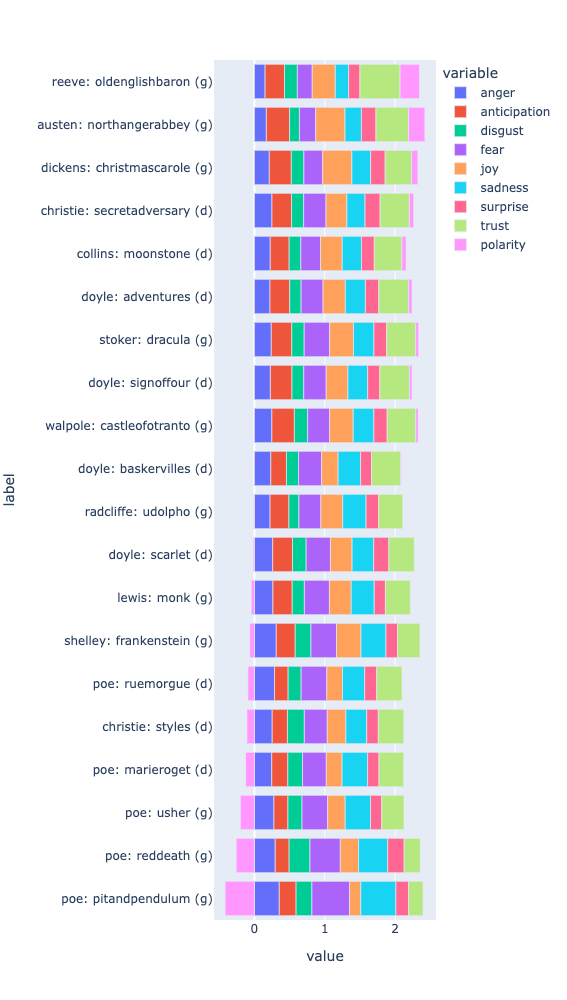

In [110]:
px.bar(BOOKS.reset_index().sort_values('polarity'), emo_cols, 'label', orientation='h', height=1000)

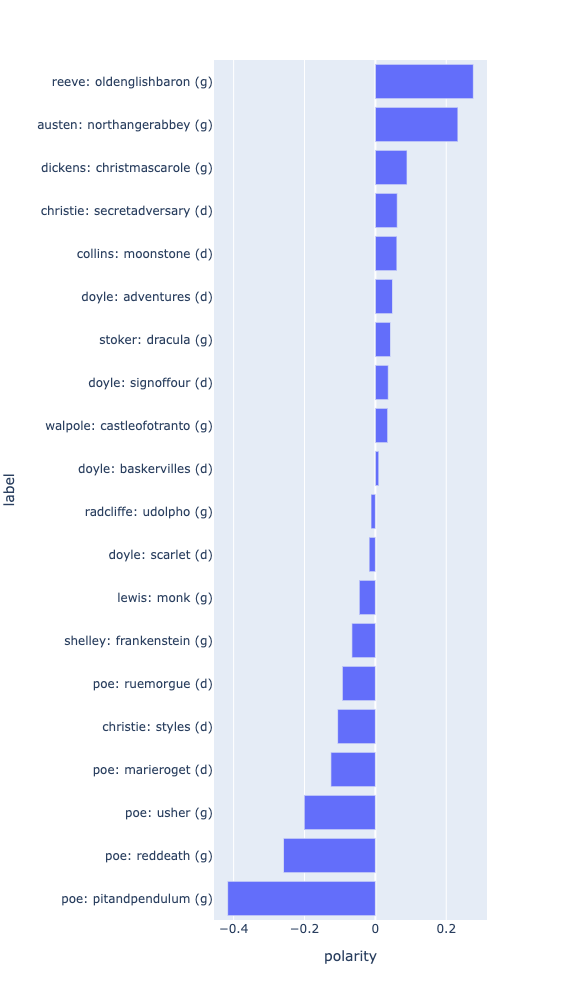

In [111]:
px.bar(BOOKS.reset_index().sort_values('polarity'), 'polarity', 'label', orientation='h', height=1000)

In [102]:
# BOOKS.sort_values('polarity').plot.barh(figsize=(10,25));

# Compare Dracula and Northanger Abbey

<AxesSubplot:>

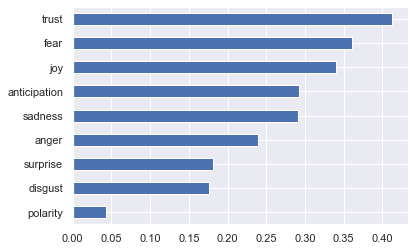

In [112]:
BOOKS.loc['dracula', emo_cols].sort_values().plot.barh()

<AxesSubplot:>

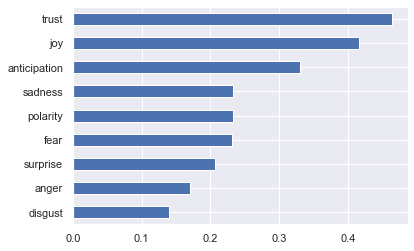

In [113]:
BOOKS.loc['northangerabbey', emo_cols].sort_values().plot.barh()

# Mean Sentiment by Chapter

In [77]:
CHAPS = COMBO.groupby(OHCO[:2])[emo_cols+['tfidf']].mean()

In [114]:
CHAPS.loc['northangerabbey'].style.background_gradient(cmap='GnBu', high=.5, axis=None)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity,tfidf
chap_id,,,,,,,,,,
1,0.153153,0.351351,0.153153,0.135135,0.540541,0.234234,0.270270,0.531532,0.306306,0.001617
2,0.131944,0.375000,0.111111,0.201389,0.500000,0.187500,0.215278,0.513889,0.416667,0.001086
3,0.058252,0.330097,0.077670,0.097087,0.427184,0.145631,0.252427,0.611650,0.611650,0.001206
4,0.115942,0.420290,0.086957,0.159420,0.652174,0.130435,0.231884,0.507246,0.492754,0.001883
5,0.120000,0.346667,0.160000,0.186667,0.520000,0.226667,0.226667,0.453333,0.400000,0.001568
6,0.169811,0.349057,0.235849,0.235849,0.490566,0.245283,0.292453,0.396226,0.226415,0.001209
7,0.117647,0.342246,0.122995,0.197861,0.513369,0.176471,0.160428,0.545455,0.433155,0.001024
8,0.064516,0.360215,0.102151,0.091398,0.467742,0.166667,0.236559,0.510753,0.387097,0.001374
9,0.136986,0.324201,0.127854,0.219178,0.429224,0.237443,0.232877,0.520548,0.214612,0.000902


In [115]:
CHAPS.loc['dracula'].style.background_gradient(cmap='GnBu', high=.5, axis=None)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity,tfidf
chap_id,,,,,,,,,,
1,0.265625,0.246875,0.137500,0.381250,0.328125,0.331250,0.134375,0.353125,-0.068750,0.000588
2,0.207143,0.225000,0.135714,0.239286,0.350000,0.235714,0.107143,0.496429,0.157143,0.000443
3,0.261838,0.292479,0.169916,0.362117,0.359331,0.270195,0.183844,0.417827,0.072423,0.000410
4,0.317901,0.253086,0.216049,0.422840,0.253086,0.283951,0.175926,0.345679,-0.101852,0.000512
5,0.176471,0.366516,0.135747,0.266968,0.497738,0.239819,0.226244,0.479638,0.262443,0.000781
6,0.242915,0.352227,0.170040,0.319838,0.429150,0.291498,0.206478,0.429150,0.052632,0.000577
7,0.305405,0.227027,0.121622,0.440541,0.208108,0.262162,0.175676,0.329730,-0.164865,0.000820
8,0.227666,0.386167,0.138329,0.337176,0.400576,0.270893,0.224784,0.461095,0.146974,0.000615
9,0.226804,0.353093,0.177835,0.335052,0.394330,0.296392,0.216495,0.386598,0.123711,0.000506


In [21]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

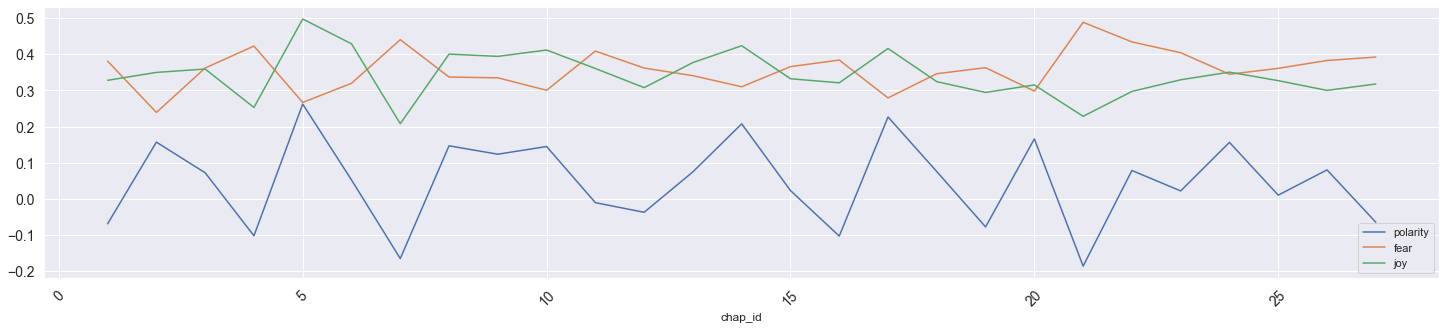

In [120]:
CHAPS.loc['dracula'][['polarity', 'fear','joy']].plot(**FIG);

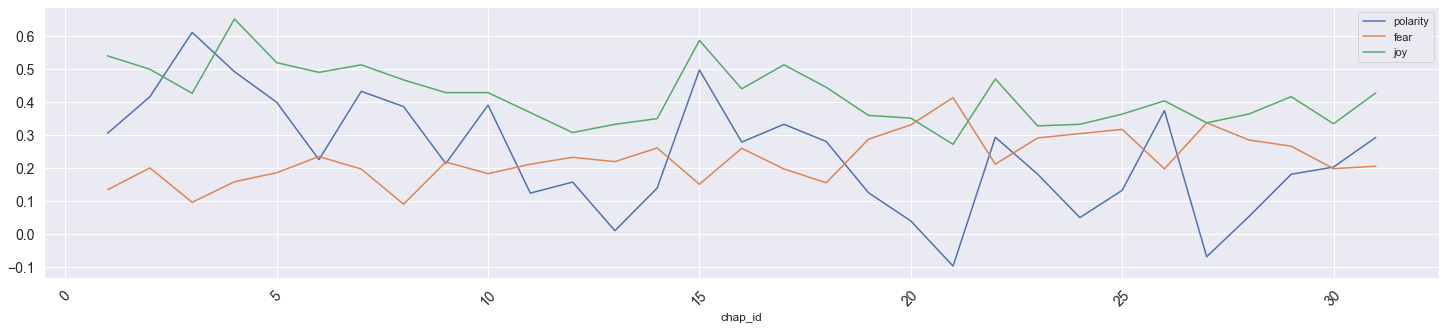

In [121]:
CHAPS.loc['northangerabbey'][['polarity', 'fear','joy']].plot(**FIG);

# Close Read Sentiment in Texts

In [31]:
COMBO['html'] = COMBO.fillna(0).apply(lambda x: f"<spdan class='sent{int(np.sign(x['polarity']))}'>{x.term_str}</span>", 1)

In [32]:
COMBO.html.head()

book_id     chap_id  para_num  sent_num  token_num
adventures  1        0         1         0                   <span class='sent0'>a</span>
                                         1            <span class='sent-1'>scandal</span>
                                         2                  <span class='sent0'>in</span>
                                         3             <span class='sent0'>bohemia</span>
                     1         0         0                   <span class='sent0'>i</span>
Name: html, dtype: object

In [33]:
SENTENCES = COMBO.groupby(OHCO[:-1])[emo_cols].mean() #.term_str.count().to_frame('n').join(LIB).join(SALEX)

In [34]:
SENTENCES

anger  anticipation  disgust  \
book_id    chap_id para_num sent_num                                    
adventures 1       0        1         0.000000           0.0      0.0   
                   1        0              NaN           NaN      NaN   
                   2        0              NaN           NaN      NaN   
                            1              NaN           NaN      NaN   
                            2         0.000000           1.0      0.0   
...                                        ...           ...      ...   
usher      1       47       0         0.000000           0.0      1.0   
                            1         0.666667           0.0      0.0   
                            2         0.500000           0.0      0.0   
                            3         0.000000           1.0      0.0   
                            4         0.600000           0.0      0.2   

                                          fear       joy  sadness  surprise  \
book_id    chap_id para_num sent_num                                          
adventures 1       0        1         1.000000  0.000000      0.0       0.0   
                   1        0              NaN       NaN      NaN       NaN   
                   2        0              NaN       NaN      NaN       NaN   
                            1              NaN       NaN      NaN       NaN   
                            2         0.000000  1.000000      0.0       0.0   
...                                        ...       ...      ...       ...   
usher      1       47       0         1.000000  0.000000      0.0       1.0   
                            1         0.333333  0.333333      0.0       0.0   
                            2         0.500000  0.000000      0.5       1.0   
                            3         0.000000  1.000000      0.0       0.0   
                            4         0.800000  0.200000      0.0       0.0   

                                         trust  polarity  
book_id    chap_id para_num sent_num                      
adventures 1       0        1         0.000000 -1.000000  
                   1        0              NaN       NaN  
                   2        0              NaN       NaN  
                            1              NaN       NaN  
                            2         1.000000  1.000000  
...                                        ...       ...  
usher      1       47       0         0.000000 -1.000000  
                            1         0.333333 -0.333333  
                            2         0.000000 -1.000000  
                            3         1.000000  1.000000  
                            4         0.400000 -0.200000  

[84282 rows x 9 columns]

In [35]:
SENTENCES['html_str'] = COMBO.groupby(OHCO[:-1]).html.apply(lambda x: x.str.cat(sep=' '))

In [36]:
def sample_sentences(df, sample_size=10, emo='polarity'):

    rows = []
    sample = df.dropna().sample(sample_size).index    
    for idx in sample:
        valence = round(df.loc[idx, emo], 4)
        id_label = ' '.join([str(i) for i in idx]).upper()
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z = 0
        rows.append("""
        <tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
            <td style="width:20%;">{1}</td>
            <td style="width:70%;">{2}</td>
            <td>{3}</td>
        </tr>
        """.format(color, id_label, df.loc[idx, 'html_str'], valence))   

    css = """
    #sample1 td {font-size:110%;vertical-align:top;text-align:left;} 
    #sample1 th {font-size:120%;vertical-align:top;text-align:left;} 
    .sent-1 {color:red;font-weight:bold;} 
    .sent1 {color:green;font-weight:bold;}
    """
    display(HTML(f'<style>{css}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentence</th><th>ID</th><th>Sentiment</th></tr>'+''.join(rows)+'</table>'))

In [123]:
sample_sentences(SENTENCES.loc['dracula'])

Sentence,ID,Sentiment
21 30 7,i got up and looked out and he raised his hands and seemed to call out without using any words,-1.0
21 46 20,guard her while i look for him,1.0
15 101 4,what have i done to you that you should torture me so,-1.0
14 19 0,i rose and bowed and he came towards me a man of medium weight strongly built with his shoulders set back over a broad deep chest and a neck well balanced on the trunk as the head is on the neck,0.0
21 62 5,well i saw i must try to help the medicine to its work with my will if it was to do me any good so i resolutely set myself to sleep,1.0
23 60 1,the answer came in a neutral way,0.0
17 70 5,with a sob he laid his head on my shoulder and cried like a wearied child whilst he shook with emotion,0.3333
27 2 14,i write this whilst we wait in a farmhouse for the horses to be got ready,-1.0
14 35 2,when i came back i found him walking hurriedly up and down the room his face all ablaze with excitement,1.0
18 82 0,when i was leaving the room last of our party he said to me in a quiet well bred voice,1.0


In [124]:
sample_sentences(SENTENCES.loc['northangerabbey'])

Sentence,ID,Sentiment
19 28 8,their hearts are open to each other as neither heart can be to you they know exactly what is required and what can be borne and you may be certain that one will never tease the other beyond what is known to be pleasant,0.0
4 3 1,the name seemed to strike them all and after speaking to her with great civility the eldest young lady observed aloud to the rest how excessively like her brother miss morland is,0.3333
6 22 0,it is not like udolpho at all but yet i think it is very entertaining,1.0
16 15 1,they retired whispering together and though her delicate sensibility did not take immediate alarm and lay it down as fact that captain tilney must have heard some malevolent misrepresentation of her which he now hastened to communicate to his brother in the hope of separating them forever she could not have her partner conveyed from her sight without very uneasy sensations,-0.1429
22 5 1,by accident or argument,-1.0
14 30 1,i have only heard that it is to be more horrible than anything we have met with yet,-1.0
12 22 1,thorpe however would see her to her chair and till she entered it continued the same kind of delicate flattery in spite of her entreating him to have done,0.0
18 28 5,with much uneasiness did she thus leave them,-1.0
12 15 0,he remained with them some time and was only too agreeable for catherine to be contented when he went away,1.0
23 17 0,catherine sometimes started at the boldness of her own surmises and sometimes hoped or feared that she had gone too far but they were supported by such appearances as made their dismissal impossible,-1.0


# Explore VADER

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [39]:
analyser = SentimentIntensityAnalyzer()

In [40]:
SENTENCES['sent_str'] = COMBO.groupby(OHCO[:-1]).term_str.apply(lambda x: x.str.cat(sep=' '))
vader_cols = [f"vader_{col}" for col in "neg neu pos compound".split()]
SENTENCES[vader_cols] = SENTENCES.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [41]:
SENTENCES.head()

anger  anticipation  disgust  fear  joy  \
book_id    chap_id para_num sent_num                                            
adventures 1       0        1           0.0           0.0      0.0   1.0  0.0   
                   1        0           NaN           NaN      NaN   NaN  NaN   
                   2        0           NaN           NaN      NaN   NaN  NaN   
                            1           NaN           NaN      NaN   NaN  NaN   
                            2           0.0           1.0      0.0   0.0  1.0   

                                      sadness  surprise  trust  polarity  \
book_id    chap_id para_num sent_num                                       
adventures 1       0        1             0.0       0.0    0.0      -1.0   
                   1        0             NaN       NaN    NaN       NaN   
                   2        0             NaN       NaN    NaN       NaN   
                            1             NaN       NaN    NaN       NaN   
                            2             0.0       0.0    1.0       1.0   

                                                                               html_str  \
book_id    chap_id para_num sent_num                                                      
adventures 1       0        1         <span class='sent0'>a</span> <span class='sent...   
                   1        0                              <span class='sent0'>i</span>   
                   2        0         <span class='sent0'>to</span> <span class='sen...   
                            1         <span class='sent0'>i</span> <span class='sent...   
                            2         <span class='sent0'>in</span> <span class='sen...   

                                                                               sent_str  \
book_id    chap_id para_num sent_num                                                      
adventures 1       0        1                                      a scandal in bohemia   
                   1        0                                                         i   
                   2        0                to sherlock holmes she is always the woman   
                            1         i have seldom heard him mention her under any ...   
                            2         in his eyes she eclipses and predominates the ...   

                                      vader_neg  vader_neu  vader_pos  \
book_id    chap_id para_num sent_num                                    
adventures 1       0        1             0.492      0.508        0.0   
                   1        0             0.000      1.000        0.0   
                   2        0             0.000      1.000        0.0   
                            1             0.000      1.000        0.0   
                            2             0.000      1.000        0.0   

                                      vader_compound  
book_id    chap_id para_num sent_num                  
adventures 1       0        1                -0.4404  
                   1        0                 0.0000  
                   2        0                 0.0000  
                            1                 0.0000  
                            2                 0.0000

In [42]:
def vader_plot(novel_name):
    global SENTENCES
    X = SENTENCES.loc[novel_name]
    w = int(len(X)/5)
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(25,20))
    X[['vader_pos','vader_neg']].rolling(w).mean().plot(ax=axes[0], title=f'{novel_name}\npos, neg {w}');
    X['vader_neu'].rolling(w).mean().plot(ax=axes[1], title=f'{novel_name}\nneu');
    X['vader_compound'].rolling(w).mean().plot(ax=axes[2], title=f'{novel_name}\ncompound');

## Dracula

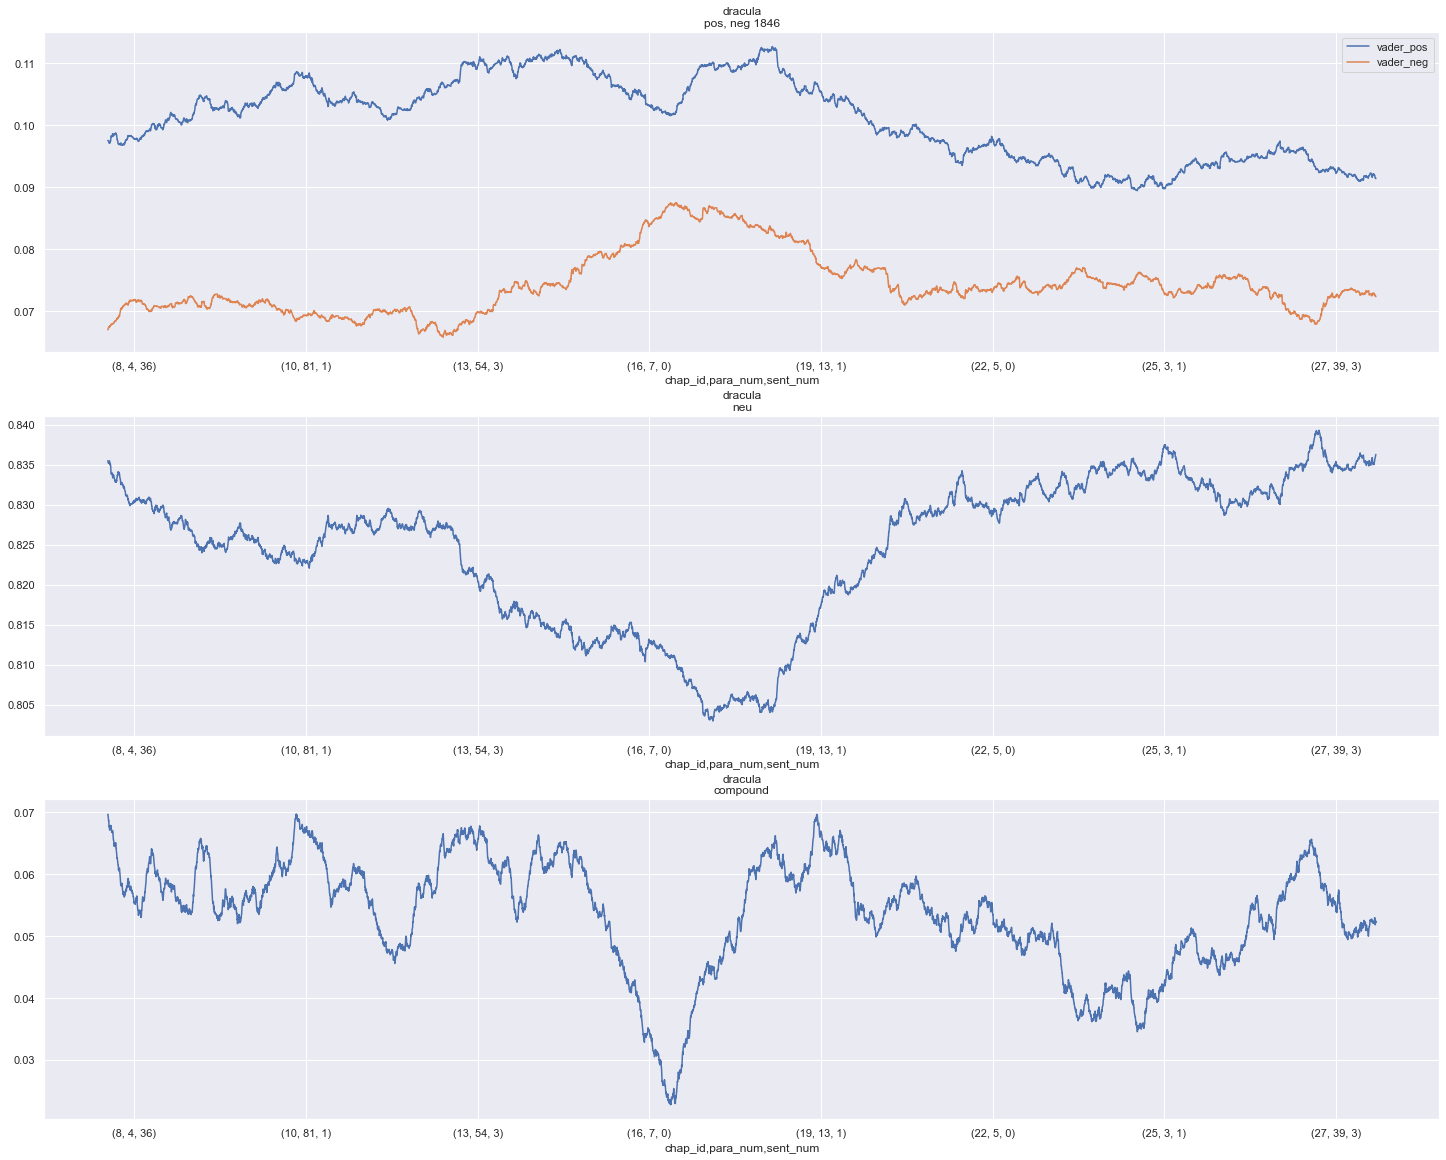

In [43]:
vader_plot('dracula')

## Northanger Abbey

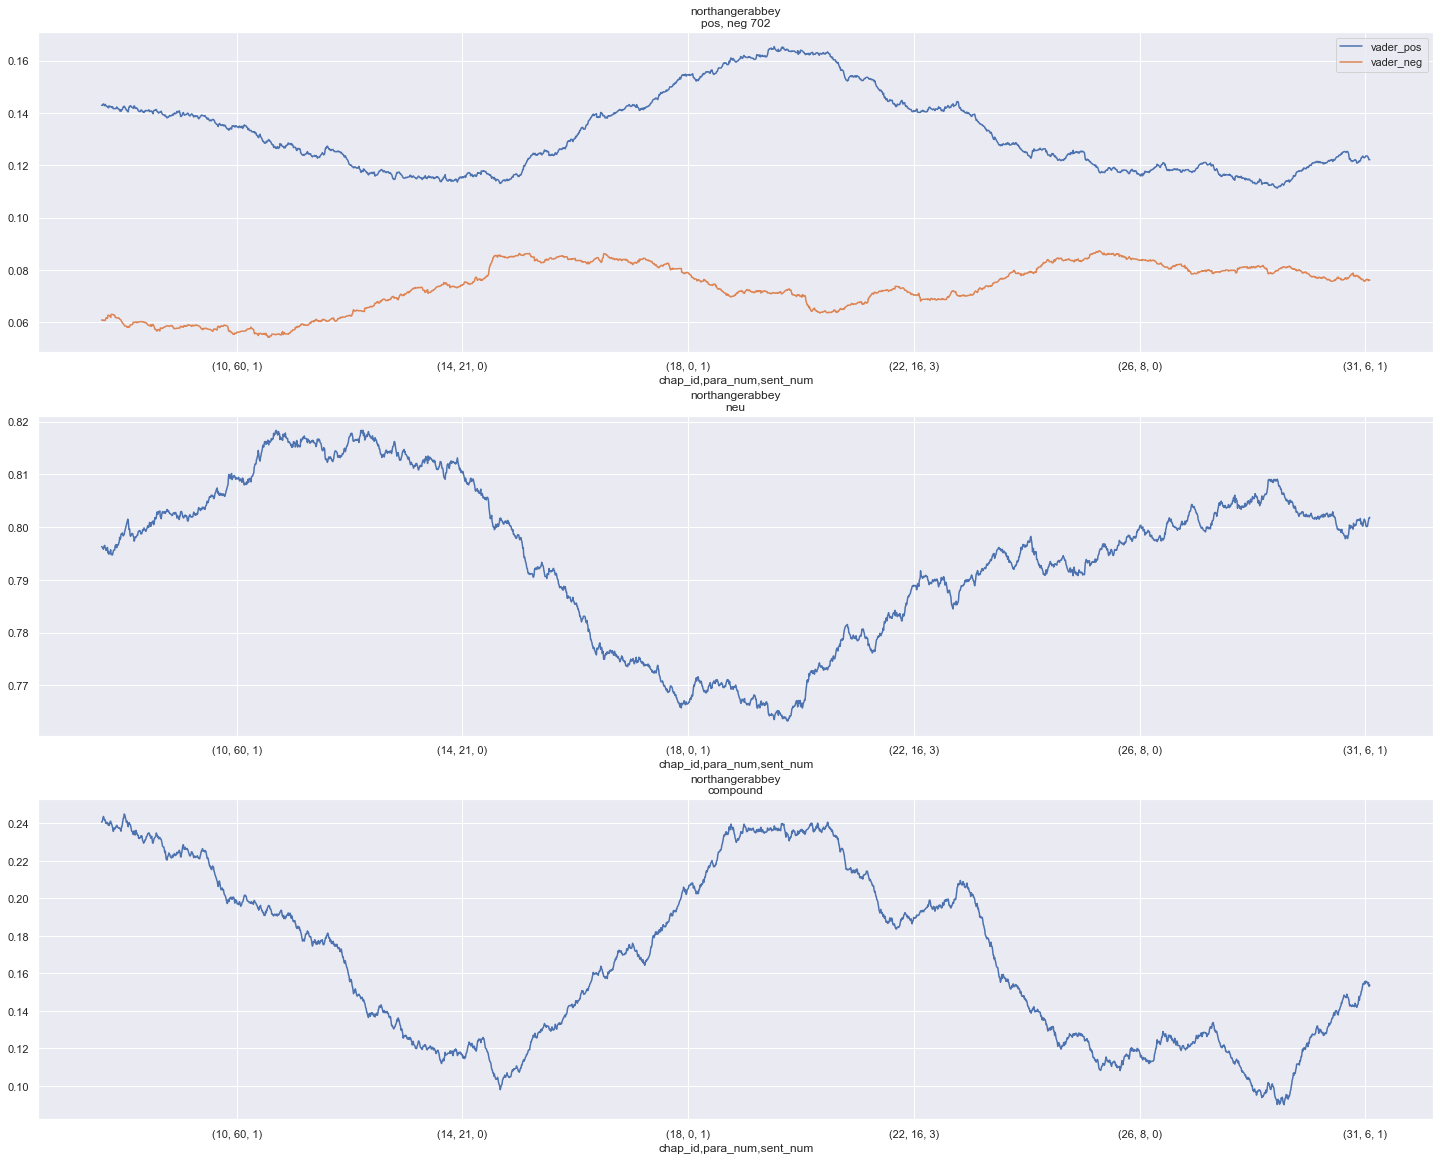

In [44]:
vader_plot('northangerabbey')

## Compare Two Novels

In [45]:
def compare_novels(novel_a, novel_b, w=10, emo='vader_compound'):
    global SENTENCES, FIG
    
    A = SENTENCES.loc[novel_a].reset_index(drop=True).reset_index().rename(columns=dict(index='seq'))
    A['cut'] = pd.cut(A.seq, 100)
    A1 = A.groupby('cut')[emo].mean().reset_index(drop=True)

    B = SENTENCES.loc[novel_b].reset_index(drop=True).reset_index().rename(columns=dict(index='seq'))
    B['cut'] = pd.cut(B.seq, 100)
    B1 = B.groupby('cut')[emo].mean().reset_index(drop=True)

    C = pd.concat([A1,B1], axis=1)
    C.columns = [novel_a, novel_b]

    plt = C.rolling(w).mean().plot(**FIG)

In [46]:
LIB.index.tolist()

['adventures',
 'baskervilles',
 'castleofotranto',
 'christmascarole',
 'dracula',
 'frankenstein',
 'marieroget',
 'monk',
 'moonstone',
 'northangerabbey',
 'oldenglishbaron',
 'pitandpendulum',
 'reddeath',
 'ruemorgue',
 'scarlet',
 'secretadversary',
 'signoffour',
 'styles',
 'udolpho',
 'usher']

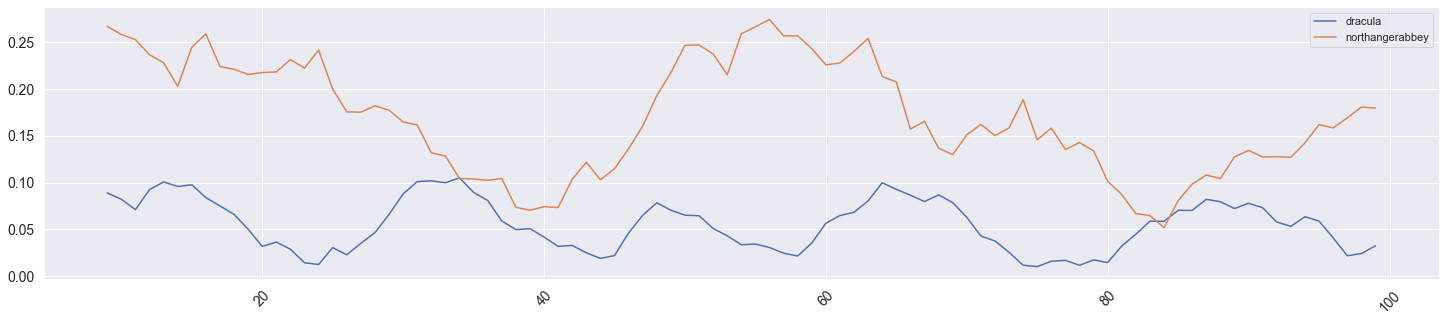

In [47]:
compare_novels('dracula','northangerabbey')

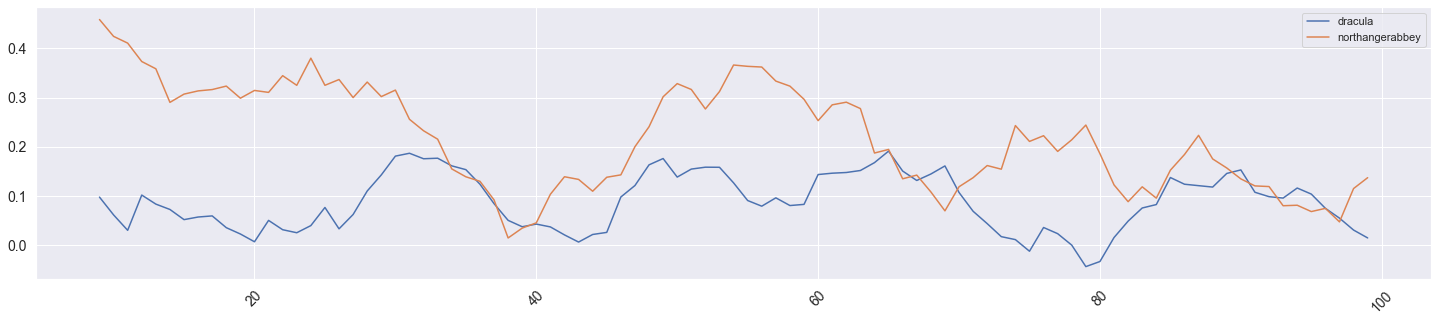

In [48]:
compare_novels('dracula','northangerabbey', emo='polarity')

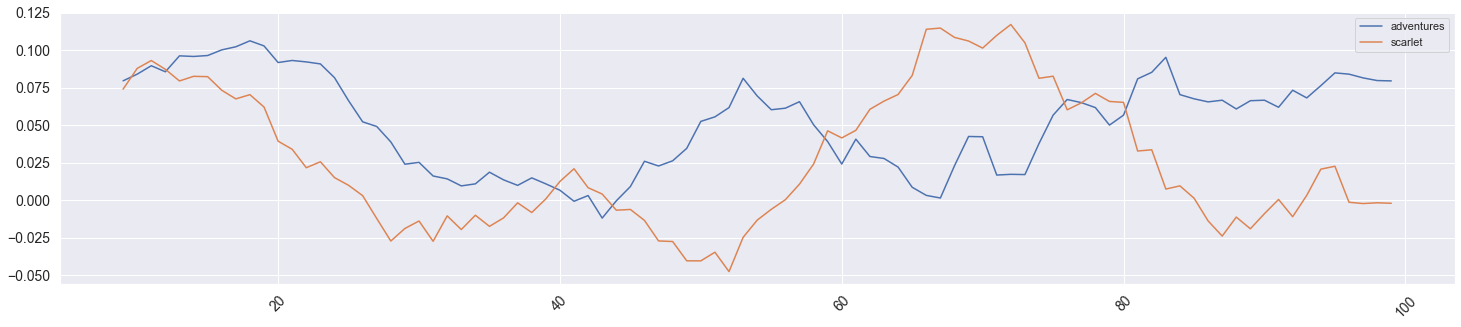

In [49]:
compare_novels('adventures','scarlet')

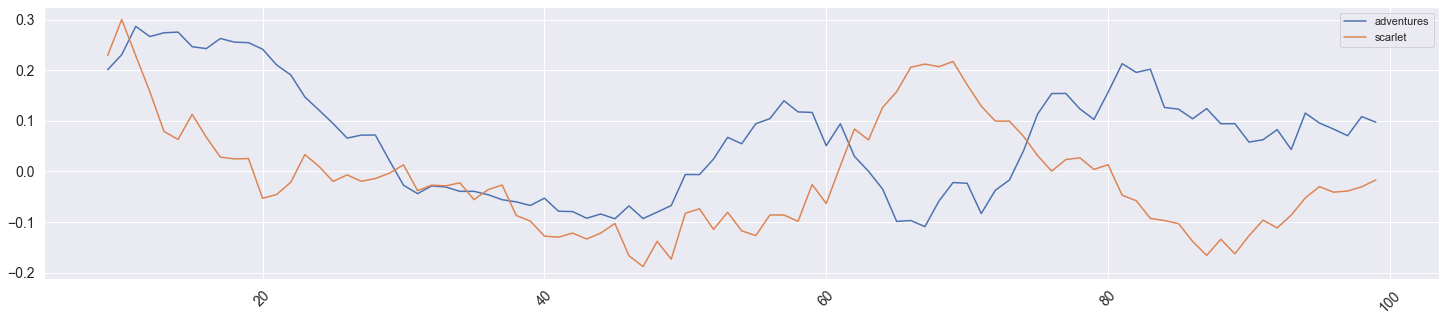

In [50]:
compare_novels('adventures','scarlet', emo='polarity')